In [1]:
%pylab inline --no-import-all
import matplotlib.ticker as ticker
import matplotlib.cm as cmap

import math
import numpy as np
import scipy.special as ssp

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

import george
from meanAndKernel import Mean, Kernel

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


# Step 2: Covariances

### You'll plot a 2D map of your covariance and correlation matrices, as well as plotting individual samples from your covariance matrix vs mjj

In [2]:
def plot_cov(X, C, K, stationary=True):
    K = K 
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("X")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("X")
    ax3.set_ylabel("X")
    


def plot_individualCov(C, K):
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    for i in range(len(K[1])):
        ax1.plot(xvalO,(K[i,:]))
    ax1.semilogy()
    ax1.set_title("Covariance vs mjj")
    
    ax2 = fig.add_subplot(132)
    ax2.semilogy()
    for i in range(len(C[1])):
        plt.plot(xvalO,C[i,:])
    ax2.set_title("Correlation vs mjj")
    
    ax3 = fig.add_subplot(133)
    ax3.plot(xvalO,(K[5,:]), c='r', label="Covariance for bin 5")
    ax3.plot(xvalO,(K[40,:]), c='g', label="Covariance for bin 40")
    ax3.plot(xvalO,(K[75,:]),c='b', label = "Covariance for bin 75")
    ax3.legend()
    ax3.semilogy()

#### Once again, make a pretty plot with multiple background realizations over data

In [3]:
def makePrettyPlots_samples(xs, ys, bkgFits, title, ymax = 2e6):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(10,10))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data")
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="Posterior samples")
        else:
            bkgPlot =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0)
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.1, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()



#### Calculate z values and chi squared goodness of fit between data and fit

In [4]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

### Grab your input data

In [5]:
ycounts = np.load("inputs/ycounts.npy")
yerrs = np.load("inputs/yerrs.npy")

xbins = np.load("inputs/xbins.npy")
xerrs = np.load("inputs/xerrs.npy")

fixedHyperparams = np.load("inputs/fixedHyperparameters.npy")

### get GP background estimate using the previously fit gaussian process hyperparameters

In [6]:
Amp, lengthscale, p0, p1, p2 = fixedHyperparams
kernel = Kernel((Amp, lengthscale))
gp = george.GP(kernel, mean=Mean((p0,p1,p2)), fit_mean = True)
gp.compute(xbins, yerrs)
meanGP, covGP = gp.predict(ycounts, xbins)

#### draw from the posterior, create a matrix from the samples, and calculate the correlation and covariance matrices

In [7]:
samps = gp.sample_conditional(ycounts, xbins, 1000)

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/george-1.0.0.dev0-py2.7-macosx-10.6-x86_64.egg/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.


In [8]:
modelMatrix=np.empty([samps.shape[0], xbins.size])
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:]
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


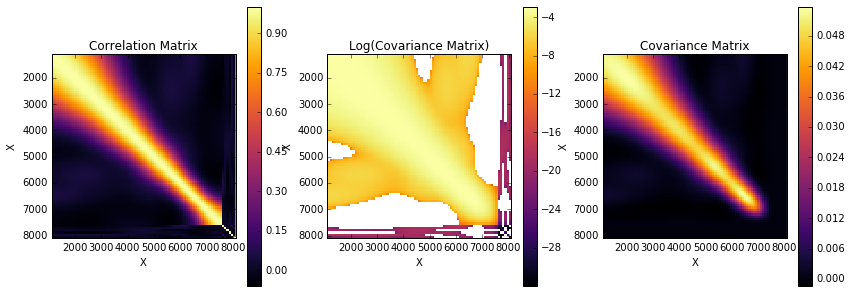

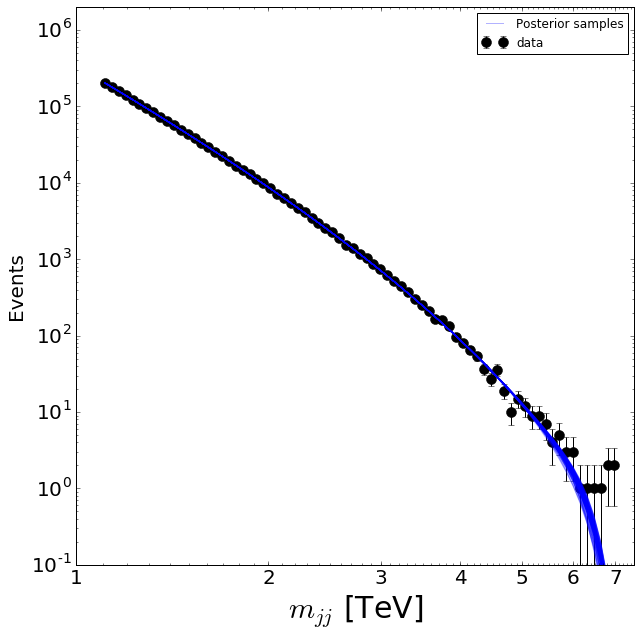

In [9]:
plot_cov(xbins, corMat, covMat, False)
makePrettyPlots_samples(xbins, ycounts, (modelMatrix[:100]).tolist(), "", ymax = 2e6)